# Importing useful libraries and loading input files

In [125]:
#libraries importing

#pd for read doc & dataframe
import pandas as pd
import spacy
#os for files loading
import os
#import re for preprocessing
import re
#import wordcloud to nicely visualise most recurrent words
from wordcloud import WordCloud
#https://towardsdatascience.com/generate-meaningful-word-clouds-in-python-5b85f5668eeb
# importing CountVectorizer to make a bag of words model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
#importing distance metrics to generate a cosine similarity matrix
# importing metrics computing polynomial_kernel with degree=1 and coef0=0
from sklearn.metrics.pairwise import linear_kernel
# importing metrics computing L2-normalized dot product of vectors
from sklearn.metrics.pairwise import cosine_similarity
# from sklearn.metrics.pairwise import cosine_similarity
# tf-idf functionality in sklearn.feature_extraction.text can produce normalized vectors,
# in which case cosine_similarity is equivalent to linear_kernel, only slower.
# source: https://scikit-learn.org/stable/modules/metrics.html

In [126]:
#models importing

#load only sm
nlp_sm = spacy.load('en_core_web_sm')
# dealing with ValueError: [E088] Text of length 7539328 exceeds maximum of 1000000.
# The parser and NER models require roughly 1GB of temporary memory per 100,000 characters in the input.
# This means long texts may cause memory allocation errors. If you're not using the parser or NER,
# it's probably safe to increase the `nlp.max_length` limit. The limit is in number of characters,
# so you can check whether your inputs are too long by checking `len(text)`.
nlp_sm.max_length = 8000000 #7539328


In [127]:
# LOADING FILES NB
START_PATH = os.path.dirname(os.getcwd())
NEWS_PATH = os.path.join(START_PATH + r'\assets\news_data.json')
CASE_PATH = os.path.join(START_PATH + r'\assets\case_data.json')
USECASES = os.path.join(START_PATH + r'\data\springboard_ai_usecases.csv')
#added for completeness but not used
ENTITIES_PATH = os.path.join(START_PATH + r'\data\custom_entities.csv')

news: pd.DataFrame = pd.read_json(NEWS_PATH)
news: pd.DataFrame = pd.json_normalize(news['data'])
case: pd.DataFrame = pd.read_json(CASE_PATH)
case: pd.DataFrame = pd.json_normalize(case['data'])

usecases: pd.DataFrame = pd.read_csv(USECASES, delimiter=';', encoding='cp1252')
#usecols=['Usecase Description', 'Type', 'Industry', 'Impact', 'Data Richness'],

# Preprocessing files to help the model

In [128]:
#PREPROCESSING
#taking small sample of 100 just for testing purpose
publications = news.loc[:, ['title','summary', 'text', 'date']]#.sample(100)
# Remove punctuation
publications['text_processed'] = \
publications['text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
publications['text_processed'] = \
publications['text_processed'].map(lambda x: x.lower())

# importing stopwords from spacy
# additional stopwords should be added to help model processing later
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
# stop word example: https://medium.com/@makcedward/nlp-pipeline-stop-words-part-5-d6770df8a936

# joining into single long text
long_string = ','.join(list(publications.loc[:, 'text_processed'].values))

#extracting named entities to add them to the stopwords later
def get_named_entities(text) -> set:
    doc = nlp_sm(text)
    named_entities = set([ent.text for ent in doc.ents])
    return named_entities

# udpate temporarily removed due to
# MemoryError: Unable to allocate 1.45 GiB for an array with shape (1351203, 288) and data type float32
#spacy_stopwords.update(get_named_entities(long_string))
#to be replaced with filtering on NER detection

# Function to preprocess text
def preprocess(text):
  	# Create Doc object
    # loading nlp keeping standard pipeline #https://spacy.io/usage/processing-pipelines
    # in particular ner to remove names later
    doc = nlp_sm(text, disable=['ner', 'parser'])
    # Generate lemmas
    lemmas = [token.lemma_ for token in doc]
    # Remove stopwords and non-alphabetic characters
    a_lemmas = [lemma for lemma in lemmas
            if lemma.isalpha() and lemma not in spacy_stopwords]
    return ' '.join(a_lemmas)

# Apply preprocess to ted['transcript']
publications['text_processed'] = publications['text_processed'].apply(preprocess)

# Showing two examples
publications.head(2)

,title,summary,text,date,text_processed
0,"ZingBox aims for ‘Internet of Trusted Things’,...",Cybersecurity provider ZingBox has announced t...,Cybersecurity provider ZingBox has announced t...,2017-04-25,cybersecurity provider zingbox announce launch...
1,AI may help create more sustainable data centres,Enterprise data centre provider Aegis Data arg...,Enterprise data centre provider Aegis Data arg...,2017-04-25,enterprise datum centre provider aegis datum a...


## Removal of names identified through NER (to be discussed ?)
In theory it should help the model rather than keeping names in the hope that reseachers/companies will
help the model to detect use cases.

# Overview of most common words
Showing most common words in all the documents to identify possible additional words to be added
## Words cloud

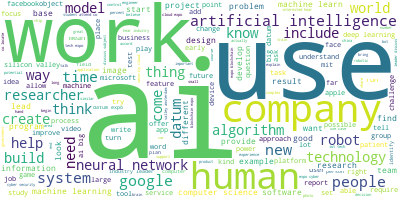

In [129]:
#join all publications into single strings to check most recurrent words in ALL documnets
long_string = ','.join(list(publications.loc[:, 'text_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

## Frequency dictionary

In [130]:
# create a dictionary of word frequencies
text_dictionary = wordcloud.process_text(long_string)
# sort the dictionary. reverse starting most common ones
word_freq={k: v for k, v in sorted(text_dictionary.items(),reverse=True, key=lambda item: item[1])}

#use words_ to print relative word frequencies
rel_freq=wordcloud.words_

#print results for top 5
print(r'Absolute frequency', '\n',list(word_freq.items())[:5])
print(r'Relative frequency', '\n', list(rel_freq.items())[:5])

Absolute frequency 
 [('ai', 3371), ('use', 3037), ('work', 2926), ('company', 2294), ('human', 2049)]
Relative frequency 
 [('ai', 1.0), ('use', 0.9009196084247998), ('work', 0.8679916938593889), ('company', 0.6805102343518243), ('human', 0.6078315040047464)]


## Considerations/Notes
Some names were not removed like: google, zurich, zuckerberg

#NLP modelling

## Building a bag of words model (see [Datacamp](https://campus.datacamp.com/courses/feature-engineering-for-nlp-in-python/n-gram-models?ex=1))
How to implement in a model to be discussed

In [131]:
# Create CountVectorizer object
vectorizer = CountVectorizer()

# Generate matrix of word vectors
bow_matrix = vectorizer.fit_transform(list(publications.loc[:, 'text_processed'].values))

# Convert bow_matrix into a DataFrame
bow_df = pd.DataFrame(bow_matrix.toarray())

# Map the column names to vocabulary
bow_df.columns = vectorizer.get_feature_names()

# Print bow_df
bow_df

,aa,aaa,aaai,aah,aalto,aamir,aaron,aaronson,aashin,aauw,...,zunger,zurich,zvei,zymergen,zzzkbot,école,łukasz,λxy,旷视,ﬁrst
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1621,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1622,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1623,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1624,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [132]:
#printing a few examples
print(f'zuckerberg frequency: {bow_df.loc[:,"zuckerberg"].sum()}', '\n',
      f'ai frequency: {bow_df.loc[:,"ai"].sum()}')

zuckerberg frequency: 63 
 ai frequency: 8182


## Identifying similar articles (see [Datacamp](https://campus.datacamp.com/courses/feature-engineering-for-nlp-in-python/tf-idf-and-similarity-scores?ex=11))

In [133]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

#testing with one publication
publication_title = publications.iloc[0,0]
publication_text = publications.iloc[0,2]

def pubblication_similarity(publication_title, publication_text):
    cases = case.loc[:, ['name', 'description']]
    cases = case.append({'name': publication_title , 'description': publication_text}, ignore_index=True)
    cases.loc[cases.name == publication_title, :]
    # Generate mapping between names and index
    # Replacing metadata with cases
    indices = pd.Series(cases.index, index=cases['name']) #.drop_duplicates()

    def get_recommendations(name, cosine_sim, indices):
        # Get index of movie that matches name
        idx = indices[name]
        # Sort the cases based on the similarity scores
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        # Get the scores for 10 most similar cases plus the found one
        # using all scores
        # sim_scores = sim_scores[1:11]
        # Get the movie indices
        # using only relative weights
        cases_indices = [i[0] for i in sim_scores]

        # Return the top 10 most similar cases
        return pd.DataFrame(dict(zip(cases['name'].iloc[cases_indices], sim_scores)))

    # Initialize the TfidfVectorizer
    tfidf = TfidfVectorizer(stop_words='english')

    # Construct the TF-IDF matrix
    tfidf_matrix = tfidf.fit_transform(cases.loc[:, 'description'])

    # Generate the cosine similarity matrix
    cosine_sim = linear_kernel(tfidf_matrix)

    # Generate recommendations
    return get_recommendations(publication_title, cosine_sim, indices)

In [134]:
df = pd.DataFrame(columns=list(case.name.unique()) + ['publication'])
for i in range(0, len(publications)):
    publication_title = publications.iloc[i, 0]
    publication_text = publications.iloc[i, 2]
    similarity = pubblication_similarity(publication_title, publication_text)
    s = similarity.iloc[1,1:].append(pd.Series([publication_title], index=['publication']))
    df = df.append(s, ignore_index=True)

In [135]:
df.loc[:, df.columns != 'publication'].max().sort_values(ascending=False)

Vision systems                       0.401984
Content Generation                   0.360422
AI developer                         0.349432
Image recognition library/SDK/API    0.333825
Deep learning library/SDK/API        0.329602
                                       ...   
Robotic Process Automation (RPA)     0.099197
PR analytics                         0.098058
Sales rep chat/email bot             0.097932
Sales attribution                    0.095502
Sales compensation                   0.087427
Length: 122, dtype: float64

# TO BE CHECKED
BERT classification
TFID